In [ ]:
import nltk
import pandas as pd
import numpy as np
import sklearn as sk
import seaborn as sns
import string
import optuna
import lightgbm as lgbm
import matplotlib.pyplot as pl
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
# from transformers import pipeline
from textblob import TextBlob
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import  CountVectorizer #bag-of-words vectorizer 
# from sklearn.decomposition import LatentDirichletAllocation  #package for LDA
from sklearn.model_selection import cross_val_score
# Bert
import torch
from transformers import BertTokenizer, BertModel
from torch import nn
from tqdm import tqdm
%matplotlib inline
%run ./ESE527_project_setup.ipynb
%run ./Text_Normalization_Function.ipynb #defining text normalization function

### Data preprocessing

In [2]:
review_data=pd.read_csv(r"C:\Users\Chuxu\ESE527\googleplaystore_user_reviews.csv")
APP_data=pd.read_csv(r"C:\Users\Chuxu\ESE527\googleplaystore.csv")
review_data.head(5)

App                                  Translated_Review  \
0  10 Best Foods for You  I like eat delicious food. That's I'm cooking ...   
1  10 Best Foods for You    This help eating healthy exercise regular basis   
2  10 Best Foods for You                                                NaN   
3  10 Best Foods for You         Works great especially going grocery store   
4  10 Best Foods for You                                       Best idea us   

  Sentiment  Sentiment_Polarity  Sentiment_Subjectivity  
0  Positive                1.00                0.533333  
1  Positive                0.25                0.288462  
2       NaN                 NaN                     NaN  
3  Positive                0.40                0.875000  
4  Positive                1.00                0.300000

In [4]:
review_null = pd.DataFrame({'Null Values':review_data.isna().sum().sort_values(ascending=False),
'Percentage Null Values':(review_data.isna().sum().sort_values(ascending=False))/(review_data.shape[0])*(100)})
review_data=review_data.dropna()
review_data.head(5)
review_data['Translated_Review']
review_data

App  \
0               10 Best Foods for You   
1               10 Best Foods for You   
3               10 Best Foods for You   
4               10 Best Foods for You   
5               10 Best Foods for You   
...                               ...   
64222  Housing-Real Estate & Property   
64223  Housing-Real Estate & Property   
64226  Housing-Real Estate & Property   
64227  Housing-Real Estate & Property   
64230  Housing-Real Estate & Property   

                                       Translated_Review Sentiment  \
0      I like eat delicious food. That's I'm cooking ...  Positive   
1        This help eating healthy exercise regular basis  Positive   
3             Works great especially going grocery store  Positive   
4                                           Best idea us  Positive   
5                                               Best way  Positive   
...                                                  ...       ...   
64222  Most ads older many agents ..not much owner po...  Positive   
64223  If photos posted portal load, fit purpose. I'm...  Positive   
64226  Dumb app, I wanted post property rent give opt...  Negative   
64227  I property business got link SMS happy perform...  Positive   
64230  Useless app, I searched flats kondapur, Hydera...  Negative   

       Sentiment_Polarity  Sentiment_Subjectivity  
0                1.000000                0.533333  
1                0.250000                0.288462  
3                0.400000                0.875000  
4                1.000000                0.300000  
5                1.000000                0.300000  
...                   ...                     ...  
64222            0.173333                0.486667  
64223            0.225000                0.447222  
64226           -0.287500                0.250000  
64227            0.800000                1.000000  
64230           -0.316667                0.400000  

[37427 rows x 5 columns]

In [5]:
def remove_punc_stopword(text):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    remove_punc = [word for word in text if word not in string.punctuation]
    remove_punc = ''.join(remove_punc)
    return [word.lower() for word in remove_punc.split() if word.lower() not in stopwords.words('english')]

In [6]:
def categorize_Sentiment(sentiment):
    if sentiment =='Positive' :
        return 2
    elif sentiment == 'Neutral':
        return 1
    elif sentiment == 'Negative':
        return 0
    else:
        return np.nan  

In [58]:
review_data['Rating Interval'] = review_data['Sentiment'].apply(categorize_Sentiment)
review_data_sample=review_data.iloc[:10000,] 
review_data_sample['Translated_Review'] = review_data_sample['Translated_Review'].apply(remove_punc_stopword)
review_data_sample['Translated_Review'] = review_data_sample['Translated_Review'].str.join(' ')
review_data_sample['Translated_Review']

0        like eat delicious food thats im cooking food ...
1               help eating healthy exercise regular basis
3               works great especially going grocery store
4                                             best idea us
5                                                 best way
                               ...                        
16010    fun relaxing game like original tetris spin pi...
16011    like game awesome constantly asks rate went ah...
16013    1st dont think asking 5 stars 1st game almost ...
16014    game could ok random blocks provided throughou...
16015    ive played lot tetris block games favorite one...
Name: Translated_Review, Length: 10000, dtype: object

In [59]:
#去除长度少于30的语句
for i in review_data_sample.index:
    if len(review_data_sample['Translated_Review'][i])<=30:
        review_data_sample=review_data_sample.drop(i)

In [60]:
review_data_sample

App  \
0      10 Best Foods for You   
1      10 Best Foods for You   
3      10 Best Foods for You   
11     10 Best Foods for You   
12     10 Best Foods for You   
...                      ...   
16010           Block Puzzle   
16011           Block Puzzle   
16013           Block Puzzle   
16014           Block Puzzle   
16015           Block Puzzle   

                                       Translated_Review Sentiment  \
0      like eat delicious food thats im cooking food ...  Positive   
1             help eating healthy exercise regular basis  Positive   
3             works great especially going grocery store  Positive   
11     useful information amount spelling errors ques...  Positive   
12     thank great app add arthritis eyes immunity ki...  Positive   
...                                                  ...       ...   
16010  fun relaxing game like original tetris spin pi...  Negative   
16011  like game awesome constantly asks rate went ah...  Positive   
16013  1st dont think asking 5 stars 1st game almost ...  Positive   
16014  game could ok random blocks provided throughou...  Negative   
16015  ive played lot tetris block games favorite one...  Positive   

       Sentiment_Polarity  Sentiment_Subjectivity  Rating Interval  
0                1.000000                0.533333                2  
1                0.250000                0.288462                2  
3                0.400000                0.875000                2  
11               0.200000                0.100000                2  
12               0.750000                0.875000                2  
...                   ...                     ...              ...  
16010           -0.016358                0.312191                0  
16011            0.122727                0.420202                2  
16013            0.111111                0.522222                2  
16014           -0.068750                0.506250                0  
16015            0.048380                0.603704                2  

[7146 rows x 6 columns]

### Word cloud

In [ ]:
review_data_sample_new = review_data_sample['Translated_Review'].values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(review_data_sample_new))

fig = plt.figure(
    figsize = (5, 4),
    facecolor = 'k',
    edgecolor = 'k')
plt.figure(figsize=(6,4))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)

### Tokenization

In [41]:
review_data_sample['Review_token']=normalize_corpus(review_data_sample['Translated_Review']) 
review_data_sample

App  \
0     10 Best Foods for You   
1     10 Best Foods for You   
3     10 Best Foods for You   
4     10 Best Foods for You   
5     10 Best Foods for You   
...                     ...   
1533            8 Ball Pool   
1534            8 Ball Pool   
1535            8 Ball Pool   
1537            8 Ball Pool   
1538            8 Ball Pool   

                                      Translated_Review Sentiment  \
0     I like eat delicious food. That's I'm cooking ...  Positive   
1       This help eating healthy exercise regular basis  Positive   
3            Works great especially going grocery store  Positive   
4                                          Best idea us  Positive   
5                                              Best way  Positive   
...                                                 ...       ...   
1533  Worst servers Iran... From first time I tried ...  Positive   
1534  Funny game never see cue battery inside. You e...  Negative   
1535  I previous profile however updates I lost 1.5 ...  Negative   
1537  Takes money different rates 11700 coins. I wen...  Negative   
1538  Great game. Use play mini clip years ago. Took...   Neutral   

      Sentiment_Polarity  Sentiment_Subjectivity  Rating Interval  \
0               1.000000                0.533333                2   
1               0.250000                0.288462                2   
3               0.400000                0.875000                2   
4               1.000000                0.300000                2   
5               1.000000                0.300000                2   
...                  ...                     ...              ...   
1533            0.013636                0.462121                2   
1534           -0.435714                0.728571                0   
1535           -0.572917                0.741667                0   
1537           -0.216667                0.366667                0   
1538            0.000000                0.583333                1   

                                           Review_token  
0     like eat delicious food cook food case best fo...  
1               help eat healthy exercise regular basis  
3                   work great especially grocery store  
4                                          best idea us  
5                                              best way  
...                                                 ...  
1533  worst server iran first time game acoutered me...  
1534  funny game never cue battery inside earn upgra...  
1535  previous profile however update lose million c...  
1537  take money different rate coin game lose round...  
1538  great game use play mini clip year ago took st...  

[1000 rows x 7 columns]

In [38]:
Review = review_data_sample["Translated_Review"]
Rating = review_data_sample["Rating Interval"]
normalized_train_reviews, normalized_test_reviews, train_polarity, test_polarity = train_test_split(Review, Rating, test_size = 0.2, random_state = 628)

#### Tfidf-Vectorizer Method

In [39]:
vectorizer = CountVectorizer()
Tfidf_vectorizer = TfidfVectorizer(ngram_range = (1,1))
feature_matrix_TRAIN = Tfidf_vectorizer.fit_transform(normalized_train_reviews).astype(float)
feature_matrix_TEST = Tfidf_vectorizer.transform(normalized_test_reviews)

#### CountVectorizer + Tfidf-Transformer

In [39]:
vectorizer = CountVectorizer()
tf_idf_transformer = TfidfTransformer()
feature_matrix_TRAIN = tf_idf_transformer.fit_transform(vectorizer.fit_transform(normalized_train_reviews)).toarray()
feature_matrix_TEST = tf_idf_transformer.transform(vectorizer.transform(normalized_test_reviews)).toarray() 

In [21]:
def objective(trial):
    params = params = {
        'n_estimators': trial.suggest_int('n_estimators', 20, 200),
        'boosting_type': trial.suggest_categorical('boosting_type',['gbdt','rf','dart']),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    model = lgbm.LGBMClassifier(**params)
    model.fit(feature_matrix_TRAIN,  train_polarity)
    k_folds = 3
    cv_scores = cross_val_score(model, feature_matrix_TRAIN,  train_polarity, cv=k_folds, scoring='accuracy')
    return np.mean(cv_scores)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)
# Get the best parameters
best_params = study.best_params
print(f"Best Params: {best_params}")

[I 2024-09-14 20:04:04,370] A new study created in memory with name: no-name-40b506ff-c4ca-4046-8abd-fb52d6d367a8


  0%|          | 0/50 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.1880168489418214, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1880168489418214
[LightGBM] [Warning] bagging_fraction is set=0.413154588318724, subsample=1.0 will be ignored. Current value: bagging_fraction=0.413154588318724
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.1880168489418214, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1880168489418214
[LightGBM] [Warning] bagging_fraction is set=0.413154588318724, subsample=1.0 will be ignored. Current value: bagging_fraction=0.413154588318724
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

In [22]:
clf_lgbm=lgbm.LGBMClassifier(**best_params)
clf_lgbm.fit(feature_matrix_TRAIN, train_polarity)
y_pred_lgbm=clf_lgbm.predict(feature_matrix_TEST)
accuracy=accuracy_score(test_polarity,y_pred_lgbm)
accuracy

[LightGBM] [Warning] feature_fraction is set=0.7106965097731659, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7106965097731659
[LightGBM] [Warning] bagging_fraction is set=0.9379584817665464, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9379584817665464
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7106965097731659, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7106965097731659
[LightGBM] [Warning] bagging_fraction is set=0.9379584817665464, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9379584817665464
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

0.87

### Bert

In [63]:
Review = review_data_sample["Translated_Review"]
Rating = review_data_sample["Rating Interval"]
train_comments, test_comments, train_labels, test_labels = train_test_split(list(Review), list(Rating), test_size = 0.2, random_state = 38)
print("length of train_comments:",len(train_comments)," length of train_comments:",len(test_comments))

length of train_comments: 5716  length of train_comments: 1430


In [64]:
print("PyTorch version: ", torch.__version__)  # 打印PyTorch版本
print("CUDA available : ", torch.cuda.is_available())  # 检查CUDA是否可用
print('There are %d GPU(s) available.' % torch.cuda.device_count())

PyTorch version:  2.4.1+cu124
CUDA available :  True
There are 1 GPU(s) available.


In [65]:
if torch.cuda.is_available():
    device = 'cuda:0' 
else:
    device = 'cpu'

In [66]:
class BERTClassifier(nn.Module):
    # 初始化加载 bert-base-chinese 原型，即Bert中的Bert-Base模型
    def __init__(self, output_dim, pretrained_name='bert-base-uncased'):
        super(BERTClassifier, self).__init__()
        # 定义 Bert 模型
        self.bert = BertModel.from_pretrained(pretrained_name)
        # 外接全连接层
        self.mlp = nn.Linear(768, output_dim)
    def forward(self, tokens_X):
        # 得到最后一层的 '<cls>' 信息， 其标志全部上下文信息
        res = self.bert(**tokens_X)
        # res[1]代表序列的上下文信息'<cls>'，外接全连接层，进行情感分析 
        return self.mlp(res[1])

In [67]:
"""
评估函数，用以评估数据集在神经网络下的精确度
"""
def evaluate(net, comments_data, labels_data):
    sum_correct, i = 0, 0
    while i <= len(comments_data):
        comments = comments_data[i: min(i + 8, len(comments_data))]
        tokens_X = tokenizer(comments, padding=True, truncation=True, return_tensors='pt').to(device=device)
        res = net(tokens_X)                                          # 获得到预测结果
        y = torch.tensor(labels_data[i: min(i + 8, len(comments_data))]).reshape(-1).to(device=device)
        sum_correct += (res.argmax(axis=1) == y).sum()              # 累加预测正确的结果
        i += 8
    return sum_correct/len(comments_data)                           # 返回(总正确结果/所有样本)，精确率

"""
训练bert_classifier分类器
"""
def train_bert_classifier(net, tokenizer, loss, optimizer, train_comments, train_labels, test_comments, test_labels,device, epochs):
    max_acc = 0.5  # 初始化模型最大精度为0.5
    # 先测试未训练前的模型精确度
    train_acc = evaluate(net, train_comments, train_labels)
    test_acc = evaluate(net, test_comments, test_labels)

    Train_acc=[]
    Test_acc=[]

    # 输出精度
    print('--epoch', 0, '\t--train_acc:', train_acc, '\t--test_acc', test_acc)

    # 累计训练18万条数据 epochs 次，优化模型
    for epoch in tqdm(range(epochs)):
        i, sum_loss = 0, 0  # 每次开始训练时， i 为 0 表示从第一条数据开始训练
        # 开始训练模型
        while i < len(train_comments):
            comments = train_comments[i: min(i + 8, len(train_comments))]  # 批量训练，每次训练8条样本数据

            # 通过 tokenizer 数据化输入的评论语句信息，准备输入bert分类器
            tokens_X = tokenizer(comments, padding=True, truncation=True, return_tensors='pt').to(device=device)

            # 将数据输入到bert分类器模型中，获得结果
            res = net(tokens_X)

            # 批量获取实际结果信息
            y = torch.tensor(train_labels[i: min(i + 8, len(train_comments))]).reshape(-1).to(device=device)

            optimizer.zero_grad()  # 清空梯度
            l = loss(res, y)  # 计算损失
            l.backward()  # 后向传播
            optimizer.step()  # 更新梯度

            sum_loss += l.detach()  # 累加损失
            i += 8  # 样本下标累加

        # 计算训练集与测试集的精度
        train_acc = evaluate(net, train_comments, train_labels)
        test_acc = evaluate(net, test_comments, test_labels)
        Train_acc.append(train_acc.cpu().numpy())
        Test_acc.append(test_acc.cpu().numpy())
        # 输出精度
        print('\n--epoch', epoch+1, '\t--loss:', sum_loss / (len(train_comments) / 8), '\t--train_acc:', train_acc,
              '\t--test_acc', test_acc)
        # 如果测试集精度 大于 之前保存的最大精度，保存模型参数，并重设最大值
        if test_acc > max_acc:
            # 更新历史最大精确度
            max_acc = test_acc
            # 保存模型
            torch.save(net.state_dict(), 'bert.parameters')
    return Train_acc, Test_acc


In [68]:
net = BERTClassifier(output_dim=3)                          # BERTClassifier分类器，因为最终结果为3分类，所以输出维度为3，代表概率分布
net = net.to(device)                                        # 将模型存放到GPU中，加速计算
# 定义tokenizer对象，用于将评论语句转化为BertModel的输入信息
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
loss = nn.CrossEntropyLoss()                                # 损失函数
optimizer = torch.optim.SGD(net.parameters(), lr=1e-4)      # 小批量随机梯度下降算法

In [69]:
Train_acc,Test_acc=train_bert_classifier(net, tokenizer, loss, optimizer, train_comments, train_labels, test_comments, test_labels, device, 15)

--epoch 0 	--train_acc: tensor(0.1074, device='cuda:0') 	--test_acc tensor(0.0937, device='cuda:0')


  0%|          | 0/15 [00:00<?, ?it/s]


--epoch 1 	--loss: tensor(0.8998, device='cuda:0') 	--train_acc: tensor(0.6148, device='cuda:0') 	--test_acc tensor(0.6622, device='cuda:0')


 13%|█▎        | 2/15 [02:54<18:57, 87.53s/it]


--epoch 2 	--loss: tensor(0.8585, device='cuda:0') 	--train_acc: tensor(0.6148, device='cuda:0') 	--test_acc tensor(0.6622, device='cuda:0')

--epoch 3 	--loss: tensor(0.8028, device='cuda:0') 	--train_acc: tensor(0.6615, device='cuda:0') 	--test_acc tensor(0.6853, device='cuda:0')


 20%|██        | 3/15 [04:23<17:36, 88.07s/it]


--epoch 4 	--loss: tensor(0.7340, device='cuda:0') 	--train_acc: tensor(0.6959, device='cuda:0') 	--test_acc tensor(0.6965, device='cuda:0')


 27%|██▋       | 4/15 [05:53<16:14, 88.59s/it]


--epoch 5 	--loss: tensor(0.6812, device='cuda:0') 	--train_acc: tensor(0.7173, device='cuda:0') 	--test_acc tensor(0.7077, device='cuda:0')


 33%|███▎      | 5/15 [07:22<14:50, 89.07s/it]


--epoch 6 	--loss: tensor(0.6404, device='cuda:0') 	--train_acc: tensor(0.7378, device='cuda:0') 	--test_acc tensor(0.7161, device='cuda:0')


 40%|████      | 6/15 [08:53<13:24, 89.41s/it]


--epoch 7 	--loss: tensor(0.6035, device='cuda:0') 	--train_acc: tensor(0.7467, device='cuda:0') 	--test_acc tensor(0.7266, device='cuda:0')


 47%|████▋     | 7/15 [10:23<11:57, 89.64s/it]


--epoch 8 	--loss: tensor(0.5667, device='cuda:0') 	--train_acc: tensor(0.7600, device='cuda:0') 	--test_acc tensor(0.7329, device='cuda:0')


 53%|█████▎    | 8/15 [11:53<10:29, 89.94s/it]


--epoch 9 	--loss: tensor(0.5300, device='cuda:0') 	--train_acc: tensor(0.7748, device='cuda:0') 	--test_acc tensor(0.7385, device='cuda:0')


 60%|██████    | 9/15 [13:23<09:00, 90.02s/it]


--epoch 10 	--loss: tensor(0.4901, device='cuda:0') 	--train_acc: tensor(0.7904, device='cuda:0') 	--test_acc tensor(0.7413, device='cuda:0')


 67%|██████▋   | 10/15 [14:54<07:31, 90.26s/it]


--epoch 11 	--loss: tensor(0.4472, device='cuda:0') 	--train_acc: tensor(0.8109, device='cuda:0') 	--test_acc tensor(0.7552, device='cuda:0')


 73%|███████▎  | 11/15 [16:25<06:01, 90.41s/it]


--epoch 12 	--loss: tensor(0.4043, device='cuda:0') 	--train_acc: tensor(0.8272, device='cuda:0') 	--test_acc tensor(0.7692, device='cuda:0')


 87%|████████▋ | 13/15 [19:25<03:00, 90.28s/it]


--epoch 13 	--loss: tensor(0.3616, device='cuda:0') 	--train_acc: tensor(0.8315, device='cuda:0') 	--test_acc tensor(0.7657, device='cuda:0')

--epoch 14 	--loss: tensor(0.3170, device='cuda:0') 	--train_acc: tensor(0.8641, device='cuda:0') 	--test_acc tensor(0.7867, device='cuda:0')


 93%|█████████▎| 14/15 [20:56<01:30, 90.22s/it]


--epoch 15 	--loss: tensor(0.2745, device='cuda:0') 	--train_acc: tensor(0.8835, device='cuda:0') 	--test_acc tensor(0.7909, device='cuda:0')


100%|██████████| 15/15 [22:26<00:00, 89.76s/it]


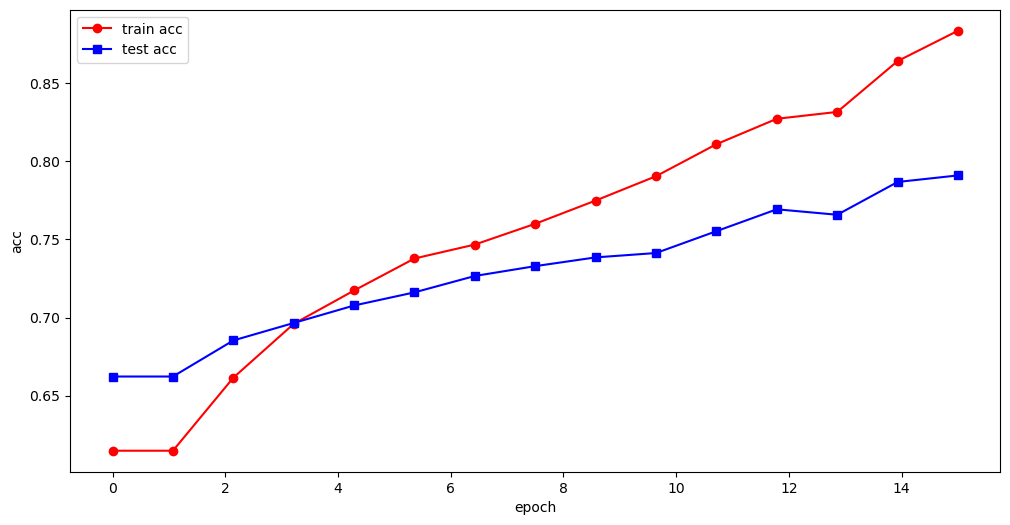

In [71]:
plt.plot(np.linspace(0,15,15), Train_acc, "ro-", label="train acc")
plt.plot(np.linspace(0,15,15), Test_acc, "bs-", label="test acc")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("acc")
plt.show()

In [72]:
# 定义模型
net = BERTClassifier(output_dim=3)
net = net.to(device)
# 加载训练好的模型参数
#net.load_state_dict(torch.load('./bert.parameters'))

start = 0
while start < 15:
    comment = test_comments[start]
    token_X = tokenizer(comment, padding=True, truncation=True, return_tensors='pt').to(device)
    label = test_labels[start]                          # 实际结果
    result = net(token_X).argmax(axis=1).item()         # 得到预测结果
    
    print(comment)
    # Predicted results
    if result == 0:
        print('Predicted results: ', 0, '----》Negative', end='\t')
    elif result == 1:
        print(' Predicted results: ', 1, '----》Neutral', end='\t')
    else:
        print(' Predicted results: ', 2, '----》Positive', end='\t')
	# Actual results
    if label == 0:
        print('Actual results: ', 0, '----》Negative', end='\t')
    elif label == 1:
        print('Actual results: ', 1, '----》Neutral', end='\t')
    else:
        print('Actual results: ', 2, '----》Positive', end='\t')

    if result == label:
        print('Correct')
    else:
        print('Wrong')

    start += 1


made airline experience lot better
 Predicted results:  2 ----》Positive	Actual results:  2 ----》Positive	Correct
simply idea opponent player picking logic many compulsion make purchase something
 Predicted results:  2 ----》Positive	Actual results:  2 ----》Positive	Correct
one thing wish apartments hunting would commute option cause really sucks cant narrow choices commute
 Predicted results:  2 ----》Positive	Actual results:  0 ----》Negative	Wrong
totally awesome little trouble times w wanted go back relisten rewind recording freaked close start
 Predicted results:  2 ----》Positive	Actual results:  2 ----》Positive	Correct
good easy accidentally spend money cannot lose page lots books
 Predicted results:  2 ----》Positive	Actual results:  2 ----》Positive	Correct
great app usually write reviews really useful keeping track birthdays actually gives notifications info disable battery saving mode kept ads keep good work
 Predicted results:  2 ----》Positive	Actual results:  2 ----》Positive	Corr